In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
a = 100 # excitatory 
ad = 50 # long-range excitatory
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

In [ ]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
# def sigmoid(v, r):
#     return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

def sigmoid(v,r):
    return 5 / (1 + np.exp(r * (6 - v)))


# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

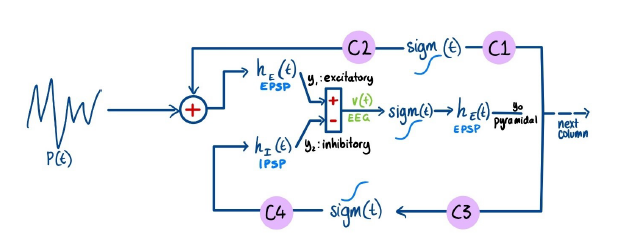

In [ ]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

norm = np.sqrt(np.sum(SC, axis = 1) * np.sum(SC, axis = 0))
# Expanded Jansen & Rit Model 
def system_of_equations(x):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * ad * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * ad * y3 - ad**2 * x3
    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


# Simulation parameters
dt = 0.001 # Step size
transient = 60  # Simulation duration for stabilizing (with Euler method)
sim_length = 600 # Simulation time points (to plot)
downsample = 4 # Downsample the simulation results

# Fixed downsampling so sampling freq matches empirical EEG (250 Hz)
# Sampling freq = 1 / dt = 1000 Hz
# Downsampling to use = current sampling freq / intended sampling freq = 1000 / 250 = 4

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.5

total_sims = int(transient + sim_length/ dt)
total_downsampled_sims = int(total_sims / downsample)

# Array to store results
sol = np.zeros((total_downsampled_sims, 8, num_nodes))
sol[0,:,:] = np.copy(initial_conditions) #First set of initial conditions
sol[0] = initial_conditions
y_temp = np.copy(initial_conditions)

# Run simulation using Euler method
for i in range(1, total_sims):
    y_temp += dt * np.array(system_of_equations(y_temp))
    if i % downsample == 0:
        sol[int(i/downsample) - 1] = np.copy(y_temp)

In [ ]:
# Plot EEG Results #################################################################
x1 = sol[:, 2]
x2 = sol[:, 4]
x3 = np.apply_along_axis(calculate_zi, axis = 1, arr = sol[:, 6])

# With vectorised operations, calculate for each simulation point
V_T = C2 * x1 - C4 * x2 + C * alpha * x3

# Take final sim_length as simulation results
V_T_plot = V_T[-sim_length:]

# Plot V_T for each node
for node in range(num_nodes):
    plt.plot(V_T_plot[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time')
plt.ylabel('V_T')
plt.title('Simulated EEG data using Jansen & Rit Model')

# Add legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
# Balloon-Windkessel Hemodynamic Model #####################################################
# Time Constants
tau_s = 0.65 # Signal decay
tau_f = 0.41 # blood inflow
tau_v = 0.98 # blood volume
tau_q = 0.98 # deoxyhemoglobin content

k = 0.32 # stiffness constant, represents resistance in veins to blood flow
E_0 = 0.4 # resting oxygen extraction rate

# Chosen Constants 
k1 = 2.77
k2 = 0.2
k3 = 0.5

V_0 = 0.03 # fraction of deoxygenated blood in resting state 


# Calculate firing rates, V_T is EEG like response, r_0 is the sigmoid slope
#firing_rates = sigmoid(V_T, r_0) # sim_length x num_nodes

# Above is from the Neuromod, but had already got firing rates before converted to voltage above, so 
# probably makes more sense to sum x1 x2 x3 (as all need blood)
raw_firing_rates = x1 + x2 + x3

# Calculate mean and standard deviation across all nodes
mean_firing_rate = np.mean(raw_firing_rates)
std_firing_rate = np.std(raw_firing_rates)

# Standardize firing rates
firing_rates = (raw_firing_rates - mean_firing_rate) / std_firing_rate

scaling = 1
# instead of multiplying by arbitrary factor, can standardise - divide by standard deviation, so sd becomes 1

# ODEs for Balloon Windkessel Model
def balloon_windkessel_ode(state, t):
    # s: vasodilatory response
    # f: blood inflow
    # v: blood volume
    # q: deoxyhemoglobin content
    s, f, v, q = state
    
    # NOTE - multiplying firing rate by a large constant
    ds_dt  = scaling * firing_rates[t] - s / tau_s - (f - 1) / tau_f
    df_dt = s
    dv_dt = (f - v**(1/k)) / tau_v
    dq_dt = ((f * (1 - (1 - E_0)**(1 / f))) / E_0 - (q * v**(1/k)) / v) / tau_q
    
    return [ds_dt, df_dt, dv_dt, dq_dt]

# Initial conditions
initial_conditions = np.array([[0.1, 1, 1, 1]] * num_nodes).T

# Array to store results
BOLD_vars = np.zeros((int(total_downsampled_sims / downsample) + 1 , 4, num_nodes))
BOLD_vars[0] = initial_conditions
BOLD_temp = np.copy(initial_conditions)

# Run simulation using Euler method, NOTE - total_downsampled_sims is the number of timepoints we have firing rates for 
for i in range(total_downsampled_sims):
    BOLD_temp += dt * np.array(balloon_windkessel_ode(BOLD_temp, i))
    if i % downsample == 0:
        # print(int(i/downsample), BOLD_temp[0][25], BOLD_temp[1][25], BOLD_temp[2][25], BOLD_temp[3][25])
        BOLD_vars[int(i/downsample)] = np.copy(BOLD_temp)

BOLD_vars_result = BOLD_vars[-sim_length:]
# Initialize BOLD array - will only take the final sim_length timepoints
BOLD_array = np.zeros((sim_length, num_nodes))


# Generate BOLD array
for t in range(sim_length):
    q = BOLD_vars_result[t, 3, :]
    v = BOLD_vars_result[t, 2, :]
    BOLD_array[t, :] = V_0 * (k1 * (1 - q) + k2 * (1 - (q/v)) + k3 * (1 - v))

# Now have a sim_lengthx100 BOLD array stored in BOLD_array
# Calculate the FC from the BOLD signal

FC_matrix = np.corrcoef(BOLD_array.T)

plt.figure(figsize=(8, 6))
plt.imshow(FC_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [ ]:
# Calculate goodness of fit for BOLD data ####################################################

# Load the empricical (averaged) FC matrix
observed_fc_matrix = np.load("fc_matrices/averaged_fc_matrix.npy")

# Flatten both and use pearson correlation to calculate goodness of fit
pearson_corr = np.corrcoef(np.ravel(FC_matrix), np.ravel(observed_fc_matrix))[0, 1]

print("Pearson correlation coefficient:", pearson_corr)


In [ ]:
from scipy.stats import pearsonr
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate PSD
def calculate_psd(data, freq, nperseg):
    window = np.hamming(nperseg)
    psd = np.zeros((data.shape[0], len(frequencies)))
    for i, channel_data in enumerate(data):
        f, power_spectrum = welch(channel_data, fs=freq, window=window, nperseg=nperseg, noverlap=nperseg//2)
        psd[i, :] = power_spectrum
    return psd

all_psd_empirical = []  # List to store all empirical PSDs

for subject_id in range(1, 15):
    raw_eeg_file = mne.io.read_raw_edf(f'eeg_sample_data/s{subject_id:02d}.edf')
    empirical_data = raw_eeg_file.get_data()

    # Scale generated data to match empirical data
    scaling_factor = np.max(empirical_data) / np.max(V_T_plot)
    scaled_gen_data = (V_T_plot * scaling_factor).T

    freq = 250
    nperseg = 50  # Number of points in output window
    frequencies = np.fft.rfftfreq(nperseg, d=1/freq)

    # Calculate PSD for generated and empirical data
    psd_gen = calculate_psd(scaled_gen_data, freq, nperseg)
    psd_empirical = calculate_psd(empirical_data, freq, nperseg)
    
    # Append empirical PSD to the list
    all_psd_empirical.append(psd_empirical)

    # Plot PSD for generated data
    plt.figure(figsize=(8, 4))
    plt.semilogy(frequencies, psd_gen.mean(axis=0), label='Generated EEG Data', color='blue')
    plt.fill_between(frequencies, psd_gen.mean(axis=0) - psd_gen.std(axis=0), psd_gen.mean(axis=0) + psd_gen.std(axis=0), alpha=0.3, color='blue')

    # Plot PSD for empirical data
    plt.semilogy(frequencies, psd_empirical.mean(axis=0), label='Empirical Data', color='red')
    plt.fill_between(frequencies, psd_empirical.mean(axis=0) - psd_empirical.std(axis=0), psd_empirical.mean(axis=0) + psd_empirical.std(axis=0), alpha=0.3, color='red')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.legend()
    plt.grid(True)
    plt.title(f'PSD Comparison for Subject s{subject_id:02d}')
    plt.show()

    # Compute and print the Pearson correlation between the PSDs
    correlation_coefficient, _ = pearsonr(psd_gen.mean(axis=0), psd_empirical.mean(axis=0))
    print("Pearson correlation coefficient between generated and empirical PSDs:", correlation_coefficient)

# Convert the list of PSDs to a numpy array and calculate the mean
all_psd_empirical = np.array(all_psd_empirical)
mean_psd_empirical = np.mean(all_psd_empirical, axis=0)

# Plot the averaged empirical PSD
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, mean_psd_empirical.mean(axis=0), label='Average Empirical Data', color='red')
plt.fill_between(frequencies, mean_psd_empirical.mean(axis=0) - mean_psd_empirical.std(axis=0), mean_psd_empirical.mean(axis=0) + mean_psd_empirical.std(axis=0), alpha=0.3, color='red')
# Plot PSD for generated data
plt.semilogy(frequencies, psd_gen.mean(axis=0), label='Generated EEG Data', color='blue')
plt.fill_between(frequencies, psd_gen.mean(axis=0) - psd_gen.std(axis=0), psd_gen.mean(axis=0) + psd_gen.std(axis=0), alpha=0.3, color='blue')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.title('Average PSD Across Subjects')
plt.show()

# Compute and print the Pearson correlation between the PSDs
correlation_coefficient, _ = pearsonr(psd_gen.mean(axis=0), psd_empirical.mean(axis=0))
print("Pearson correlation coefficient between generated and empirical PSDs:", correlation_coefficient)



 - Mapping nodes to 19 electrodes 
 - Combined goodness-of-fit
 - Approaches to parameter fitting
 - Seperating by drug and other demographics
 - Filtering data - known artifact ? 

In [ ]:
import mne
import numpy as np
import pandas as pd
from mne.datasets import fetch_fsaverage
from scipy.interpolate import NearestNDInterpolator as Interpolator
from mne.datasets import fetch_fsaverage

src = mne.read_source_spaces('C:/Users/stapl/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif')
# Get positions and orientations
fsaverage_pos = np.array(src[1]['rr'])  # Vertex positions (3, 163842). 3D, sources (ignoring left/right hemisphere)
fsaverage_ori = np.array(src[1]['nn'])  # Vertex orientations (3, 163842)

#rr coordinates, nn vector normals 

df = pd.read_csv('Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')

# schaefer_pos = df[['R', 'A', 'S']].values # produces (100, 3) where index is the ROI label
schaefer_pos = df[['R', 'A', 'S']].values.astype(float) / 1000.0 # Converting to metres to be the same as fsaverage

schaefer_ori = np.zeros(schaefer_pos.shape)

for i in range(3):
    interp = Interpolator(fsaverage_pos, fsaverage_ori[:, i])
    schaefer_ori[:, i] = interp(schaefer_pos[:, 0], schaefer_pos[:, 1], schaefer_pos[:, 2])

old_info = raw_eeg_file.info 

new_info = mne.create_info(ch_names=old_info['ch_names'], sfreq=old_info['sfreq'], ch_types='eeg')
new_info.set_montage('standard_1020')  # Set the montage to standard 10-20 system

trans = 'C:/Users/stapl/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-trans.fif'

schaefer_positions_dict = {
    'rr': schaefer_pos,
    'nn': schaefer_ori
}

source_space = mne.setup_volume_source_space(pos=schaefer_positions_dict)

print(fsaverage_pos[0])
print(schaefer_pos[0])

mne.viz.plot_alignment(
    new_info,
    trans,
    src=src,
    dig=True,
    eeg=dict(original=1),
    surfaces="brain", 
)

# mne.viz.plot_sensors(
#     new_info,
#     kind='3d'
# )


In [ ]:
# Make BEM model #######################
fs_dir = "C:/Users/stapl/mne_data/MNE-fsaverage-data/"

model = mne.make_bem_model(
    subject='fsaverage',
    ico=4,
    conductivity=(0.3, 0.006, 0.3),
    subjects_dir=fs_dir,
)

bem = mne.make_bem_solution(model)


In [ ]:
fsaverage = fetch_fsaverage(verbose=True)
subject_dir="C:/Users/stapl/mne_data/MNE-fsaverage-data"

fig = mne.viz.plot_alignment(
    trans=trans,
    subject= fsaverage,
    subjects_dir=subject_dir,
    src=source_space,
    surfaces="brain", 
)

#Getting an empty plot

In [216]:
# Create the forward solution ##################
fwd = mne.make_forward_solution(
    info=new_info,
    trans=trans,
    src=source_space,
    bem=bem,
    eeg=True,
    n_jobs=None,
    verbose=True,
)



Source space          : <SourceSpaces: [<discrete, n_used=100>] MRI (surface RAS) coords, ~8 kB>
MRI -> head transform : C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 100 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  19 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surfa

In [222]:
fwd_fixed = mne.convert_forward_solution(fwd, force_fixed=True)

# data contains The forward solution data. 
# The shape will be (n_channels, nsource) for a fixed-orientation forward and (n_channels, nsource * 3) for a free-orientation forward.
# SO must first convert to fixed orientation 

leadfield_fixed = fwd_fixed["sol"]["data"]

leadfield_normalised = (leadfield_fixed - np.min(leadfield_fixed)) / (np.max(leadfield_fixed) - np.min(leadfield_fixed))

print(V_T_plot.shape) # (150015, 100)
print(leadfield_normalised.shape) # (19, 100)

# 150015x100 * 100x19 = 150015x19
simulated_eeg = np.dot(V_T_plot, leadfield_normalised.T)
print(V_T_plot[0])
print(simulated_eeg[0])

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
